<a href="https://colab.research.google.com/github/emredeveloper/Yapay-Zeka-Denemelerim/blob/main/inference_gists/IBM_Granite_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multimodal Granite 3.1 2B

IBM released Granite-Vision-3.1-2B preview, a compact Llava-like vision language model based on Granite Instruct 3.1 for text backbone and SigLIP for image backbone.

It has very impressive [scores on different benchmarks](https://huggingface.co/ibm-granite/granite-vision-3.1-2b-preview#granite-vision-31-2b-preview) for it's size for vision understanding and document understanding.

It comes with transformers and vLLM integration from the start too! Let's put it to test.

In [1]:
!pip install -q pdf2image git+https://github.com/huggingface/transformers.git
!sudo apt-get install -q poppler-utils

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Reading package lists...
Building dependency tree...
Reading state information...
poppler-utils is already the newest version (22.02.0-2ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


## Document Understanding

We'd like to ask Granite Vision to explain a chart in a given document, and perhaps ask further questions.

In [2]:
!wget -q https://www.europarl.europa.eu/pdfs/news/expert/2018/7/story/20180706STO07407/20180706STO07407_en.pdf

In [3]:
from pdf2image import convert_from_path
import os

pdf_path = "20180706STO07407_en.pdf"
images = convert_from_path(pdf_path)

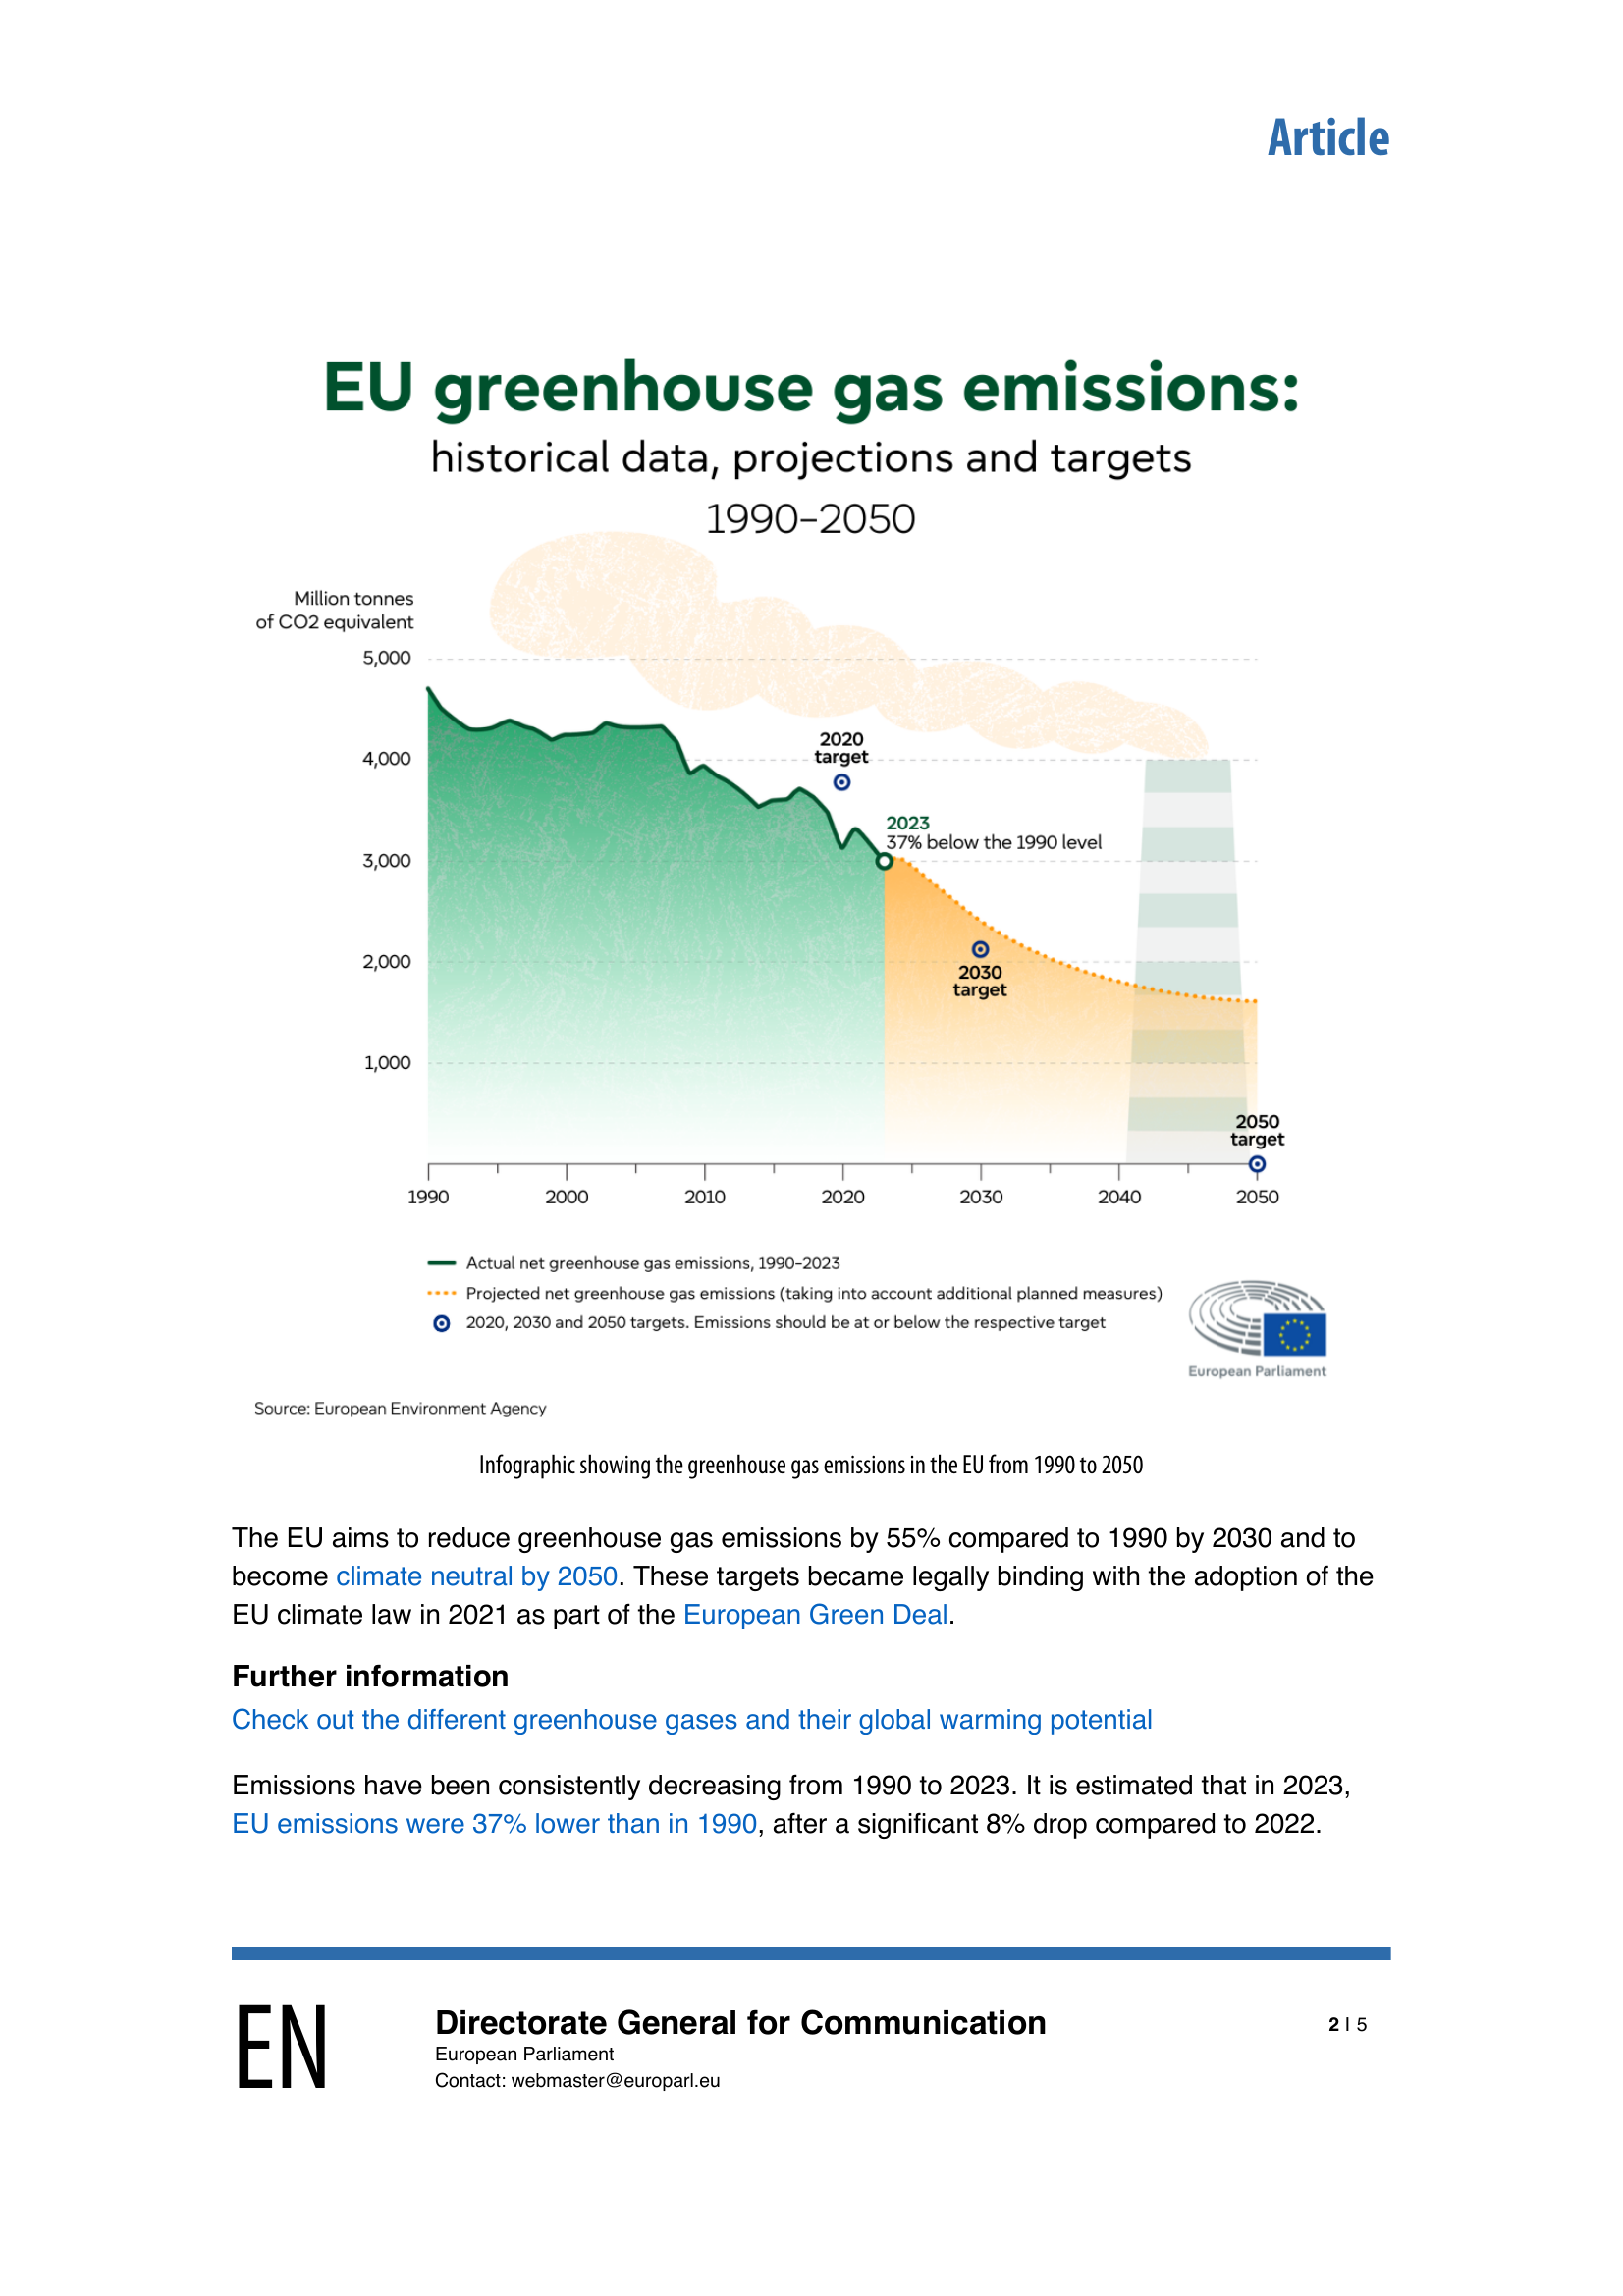

In [4]:
images[1]

We can use `LlavaNextForConditionalGeneration` class to load Granite Vision and infer.

In [5]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration

model_path = "ibm-granite/granite-vision-3.1-2b-preview"
processor = LlavaNextProcessor.from_pretrained(model_path)
model = LlavaNextForConditionalGeneration.from_pretrained(model_path, device_map="cuda:0")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We will use chat template to format our image and text input together, then pass it to the model.

In [9]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": images[1]},
            {"type": "text", "text": "what is the different beetwen 1990 and 2023 year co2 position and what is the 2050 target level"},
        ],
    },
]
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to("cuda:0")


# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=500)
print(processor.decode(output[0], skip_special_tokens=True))


<|user|>

what is the different beetwen 1990 and 2023 year co2 position and what is the 2050 target level
<|assistant|>
37% lower than in 1990


Correct answer and quite high quality generation.

## Paper Understanding

The authors report various benchmarks, one that caught my eye was LiveXiv which is about ArXiv paper understanding. Let's put it to test.

In [7]:
!wget -q https://arxiv.org/pdf/2405.04324

In [8]:
pdf_path = "/content/2405.04324"
images = convert_from_path(pdf_path)

We'll test understanding from a page of Granite Code paper of IBM.

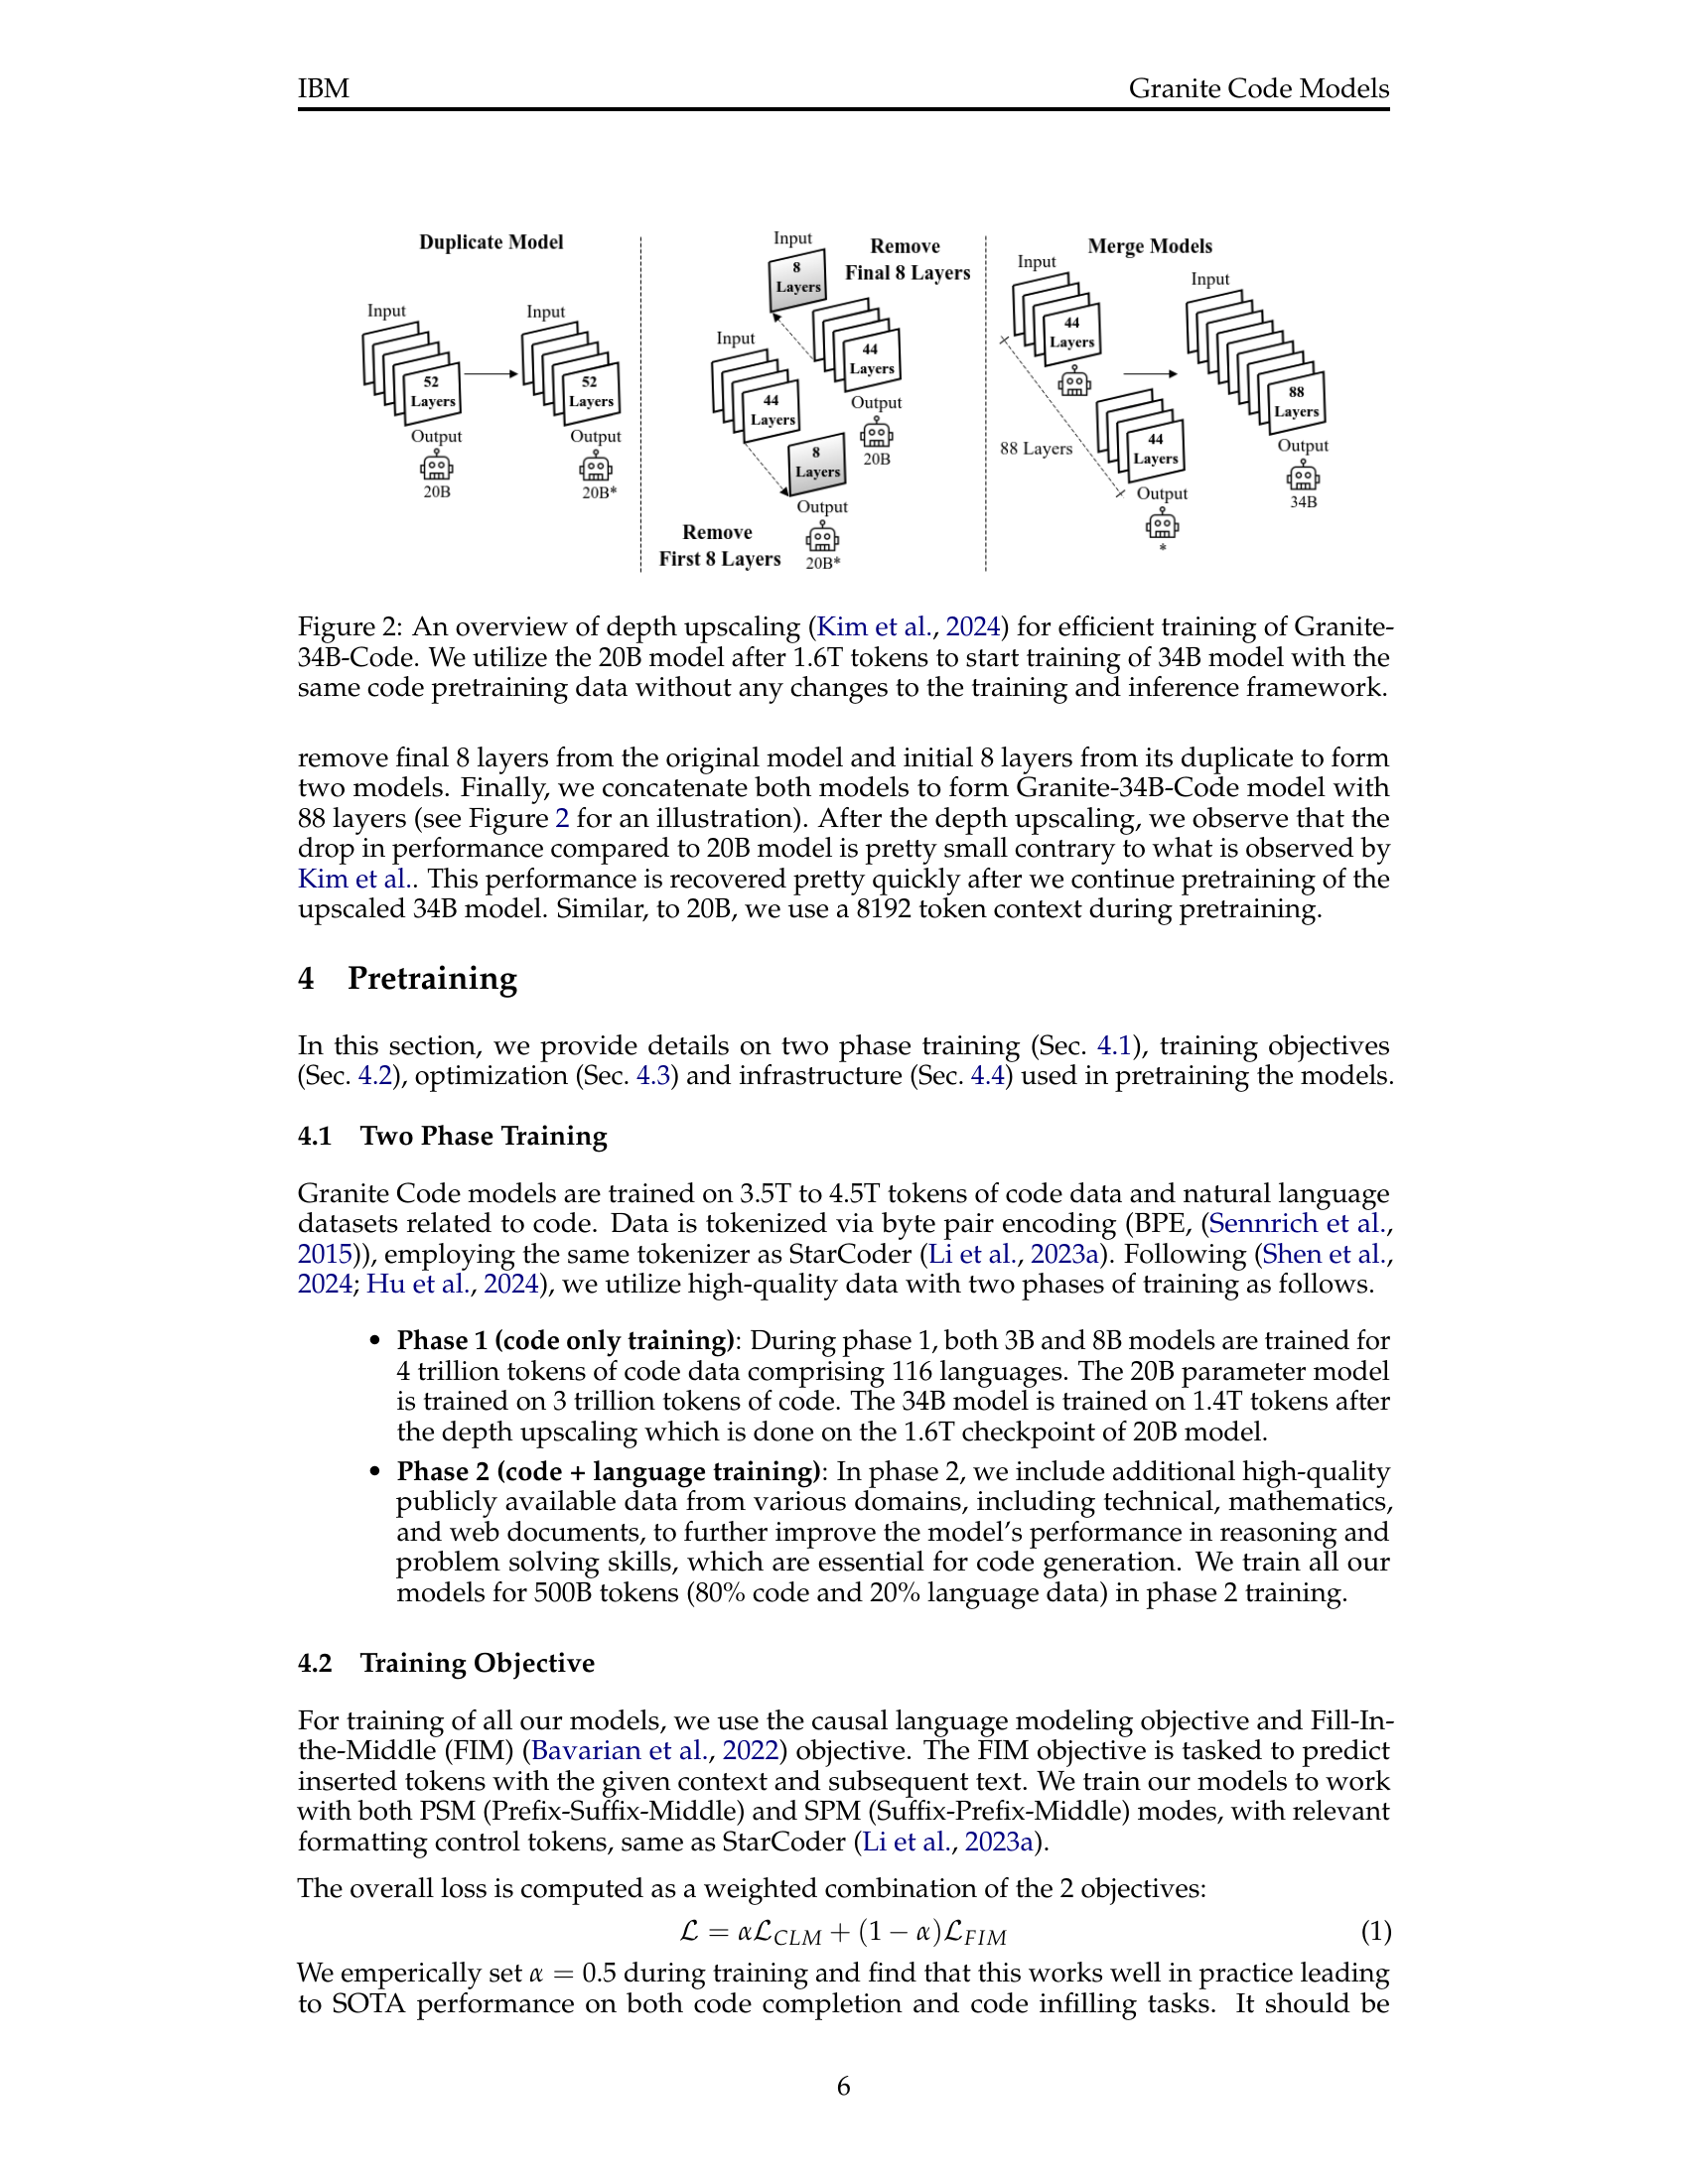

In [9]:
images[5]

In [10]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": images[5]},
            {"type": "text", "text": "What differences does this paper contribute to model architecture and training?"},
        ],
    },
]
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to("cuda:0")


# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=500)
print(processor.decode(output[0], skip_special_tokens=True))


<|user|>

What differences does this paper contribute to model architecture and training?
<|assistant|>
This paper contributes to model architecture by proposing a method for efficient training of Granite34B-Code. It introduces a depth upscaling technique that allows for the use of a 20B model as a starting point for training a 34B model with the same code pretraining data. This approach avoids changes to the training and inference framework, enhancing the model's adaptability and performance.


The answer is correct!

## Read More

Get more info about the model from [the model repository](https://huggingface.co/ibm-granite/granite-vision-3.1-2b-preview), including benchmarks, how to get started with transformers and vLLM.